<h1>Import Dataset</h1><hr>

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf

<h1>Mendefinisikan parameter dan variabel</h1><hr>

<h5>Deklarasi directory path</h5>

In [4]:
import os

base_dir = './'
train_dir = os.path.join(base_dir, '../dataset/processed')
validation_dir = os.path.join(base_dir, '../dataset/test')


<h5>Deklarasi parameter untuk model dan loader</h5>

In [5]:
batch_size = 4
total_train = 498
total_test = 50
img_size = (img_width, img_height) = (150, 150)
epochs = 10
class_list = os.listdir(train_dir)

<h1>Read Dataset</h1><hr>

In [6]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        horizontal_flip=True,
        shear_range = 0.2,
        fill_mode='nearest'
      )

test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
class_mode = 'sparse'

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode=class_mode
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode=class_mode
)

Found 498 images belonging to 5 classes.
Found 50 images belonging to 5 classes.


<h1>Dataset Augmentation Visualization</h1><hr>

In [8]:
import shutil

i = 0

if os.path.exists('../dataset/augmented/'):
    shutil.rmtree('../dataset/augmented/')

os.mkdir('../dataset/augmented/')

for batch in train_datagen.flow_from_directory('../dataset/processed/', batch_size=batch_size,target_size=img_size,
                          save_to_dir='../dataset/augmented', save_format='jpg'):
    i += 1
    if i > 2:
        break

Found 498 images belonging to 5 classes.


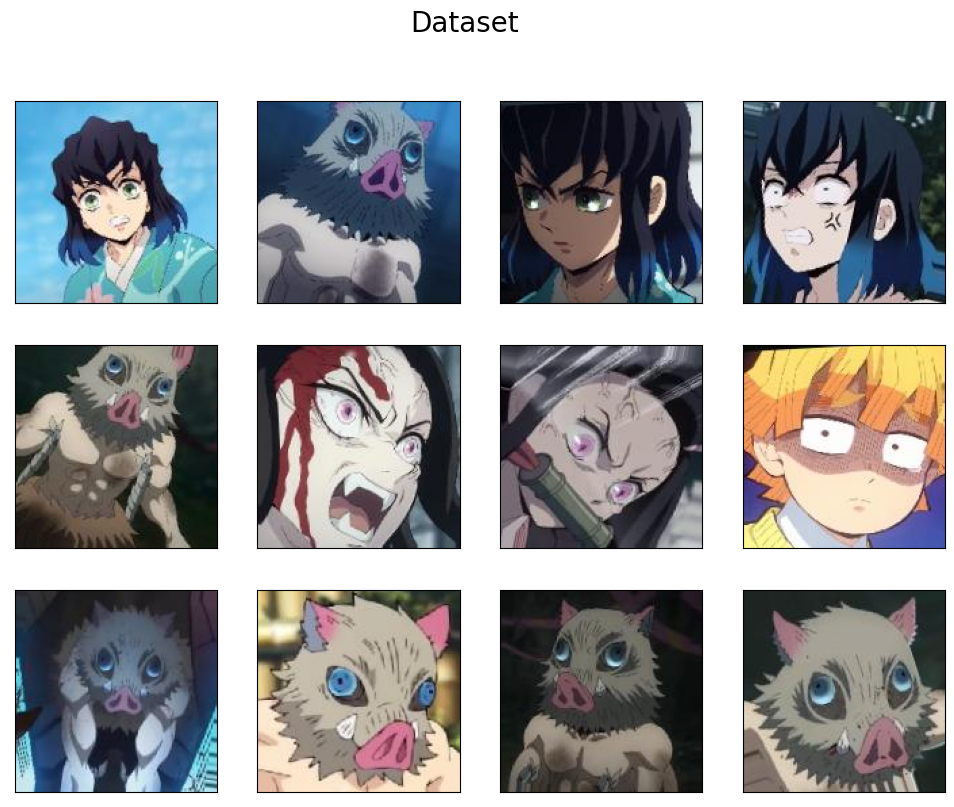

In [9]:
import matplotlib.pyplot as plt
import cv2 as cv

rows = 3
fig, axes = plt.subplots(rows, batch_size)
aug_img = []
row_img = []

for root, dirs, files in os.walk('../dataset/augmented'):
    for filename in files:
        row_img.append(os.path.join(root, filename))
        
        if len(row_img) == batch_size:
            aug_img.append(row_img)
            row_img = []

for r, row in enumerate(aug_img):
    for c, col in enumerate(row):
        image = cv.imread(col, cv.IMREAD_COLOR)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        axes[r,c].imshow(image)
        axes[r,c].set_xticks([])
        axes[r,c].set_yticks([])

fig.set_size_inches(12,9)
fig.suptitle('Dataset', fontsize=20)

plt.show()

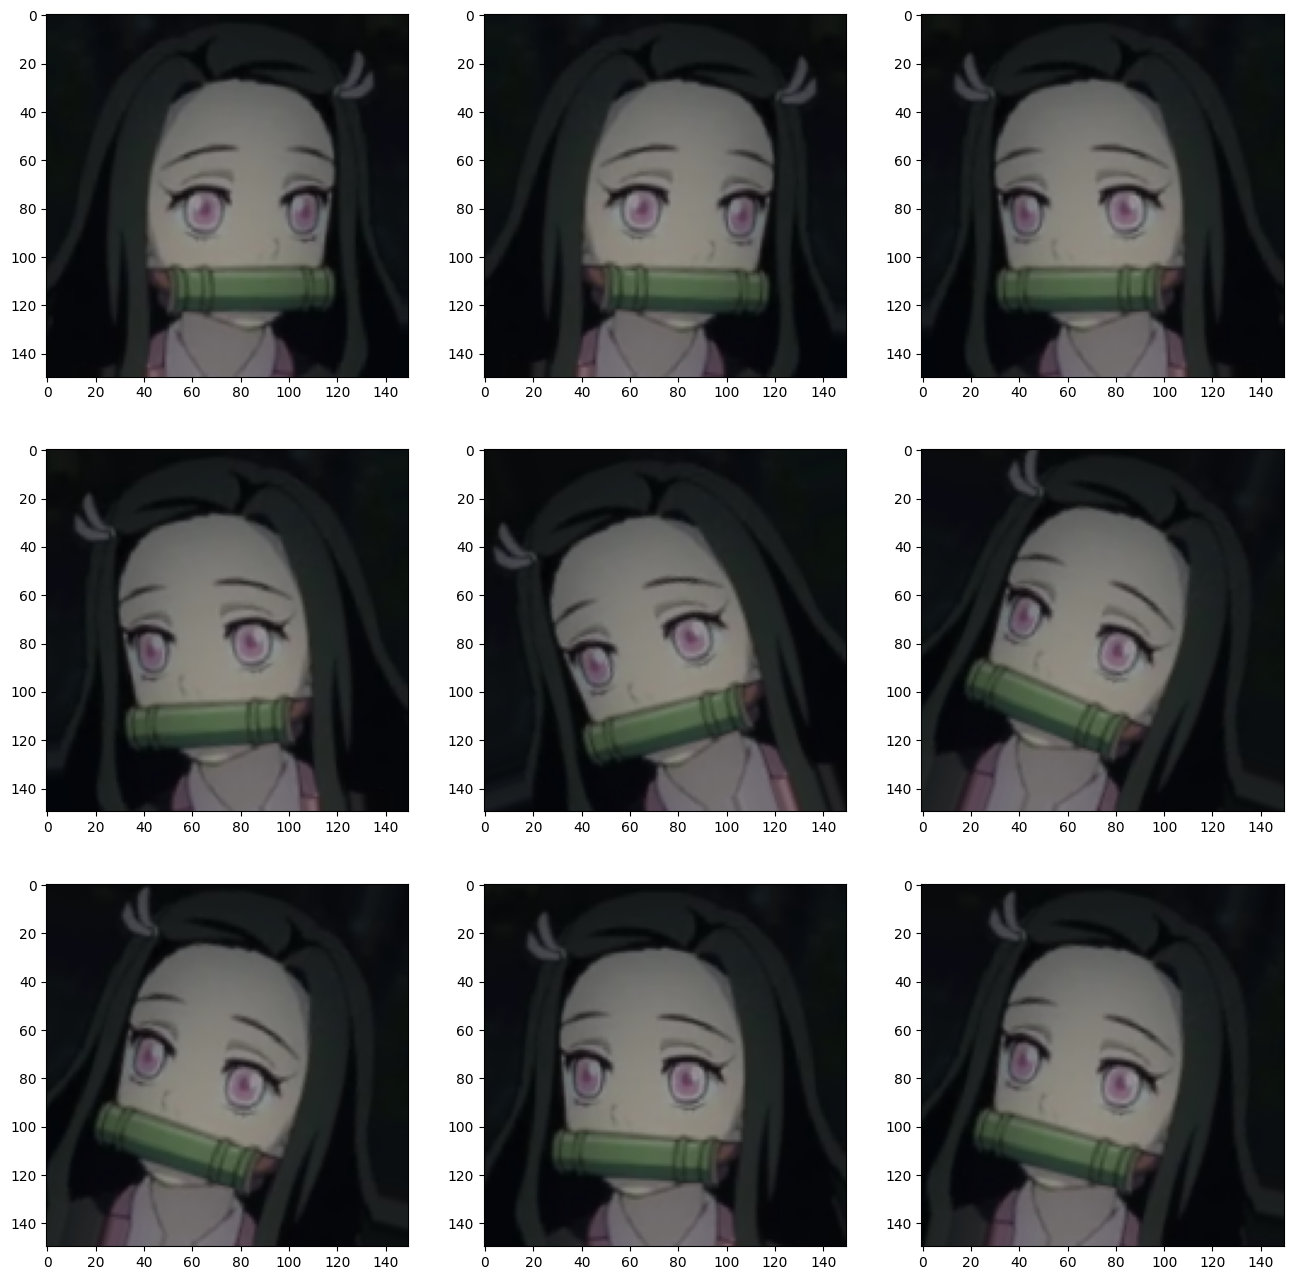

In [20]:
img = tf.keras.preprocessing.image.load_img('../dataset/processed/nezuko/10.png', target_size=img_size)
img_tensor = tf.keras.preprocessing.image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

pic = train_datagen.flow(img_tensor, batch_size=1)
plt.figure(figsize=(16, 16))
#Plots our figures
for i in range(1,10):
   plt.subplot(3, 3, i)
   batch = pic.next()
   image_ = batch[0]
   plt.imshow(image_)
plt.show()

<h1>Modelling</h1><hr>

<h5>Mendefinisikan layer dari Neural Network untuk model</h5>

In [9]:
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(img_width, img_height, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

    model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
  
    return model

In [10]:
checkpoint_path = './trained_model/model.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

<h5>Melatih model dengan data yang sudah diproses dan parameter yang didefinisikan</h5>

In [11]:
%%time

model = create_model()

model.save_weights(checkpoint_path.format(epoch=0))

model.fit(
      train_generator,
      epochs=epochs,
      steps_per_epoch=total_train//batch_size,
      validation_data=validation_generator,
      validation_steps=total_test//batch_size,
      callbacks=[cp_callback]
      )

Epoch 1/10
124/124 [==============================] - ETA: 0s - loss: 1.2608 - accuracy: 0.4555
Epoch 1: saving model to ./trained_model\model.ckpt
124/124 [==============================] - 19s 135ms/step - loss: 1.2608 - accuracy: 0.4555 - val_loss: 1.0679 - val_accuracy: 0.6458
Epoch 2/10
124/124 [==============================] - ETA: 0s - loss: 0.6394 - accuracy: 0.7530
Epoch 2: saving model to ./trained_model\model.ckpt
124/124 [==============================] - 12s 100ms/step - loss: 0.6394 - accuracy: 0.7530 - val_loss: 0.3744 - val_accuracy: 0.8750
Epoch 3/10
124/124 [==============================] - ETA: 0s - loss: 0.4084 - accuracy: 0.8522
Epoch 3: saving model to ./trained_model\model.ckpt
124/124 [==============================] - 12s 99ms/step - loss: 0.4084 - accuracy: 0.8522 - val_loss: 0.2311 - val_accuracy: 0.8958
Epoch 4/10
124/124 [==============================] - ETA: 0s - loss: 0.3215 - accuracy: 0.8806
Epoch 4: saving model to ./trained_model\model.ckpt
124/124

<h3>Visualisasi Arsitektur Model</h3>

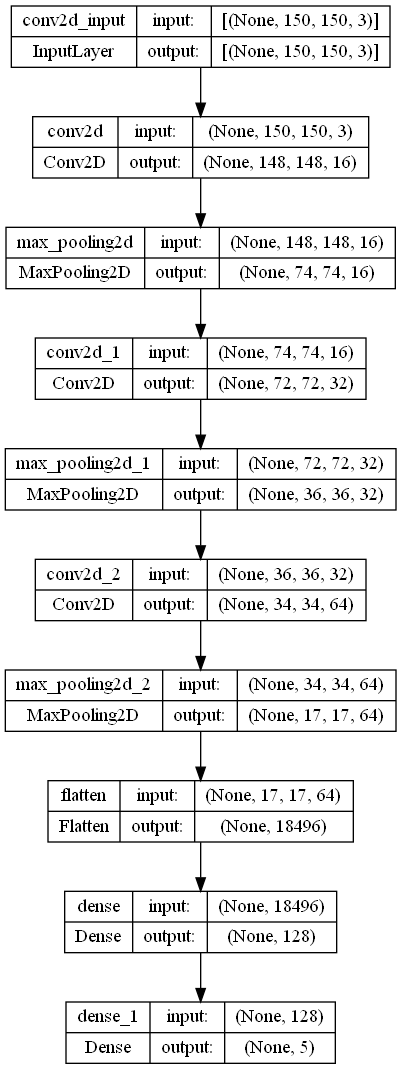

In [12]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

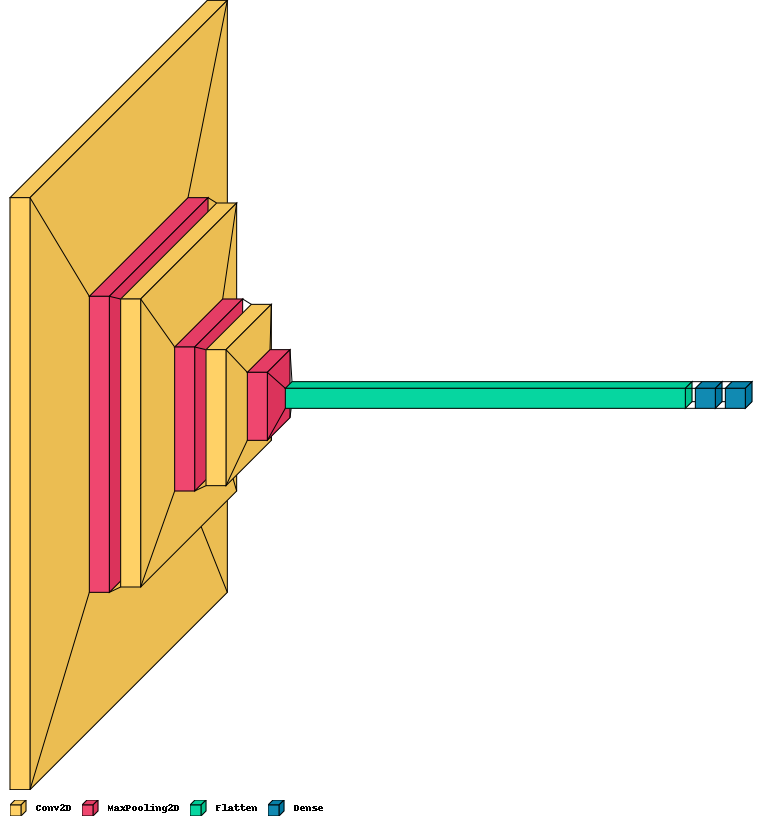

In [13]:
import visualkeras

visualkeras.layered_view(model, legend=True)

<h3>Visualisasi history pelatihan model<h3>

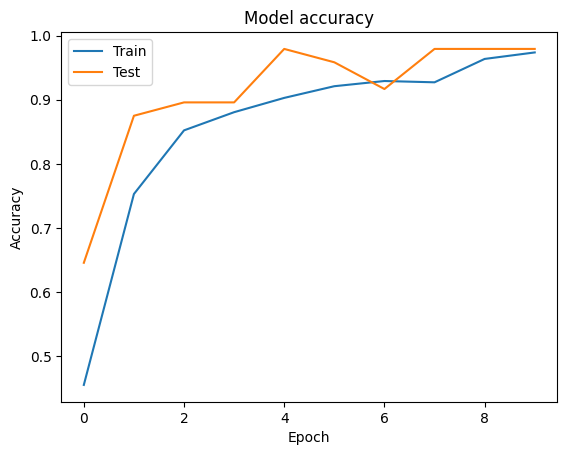

In [14]:
import matplotlib.pyplot as plt

plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

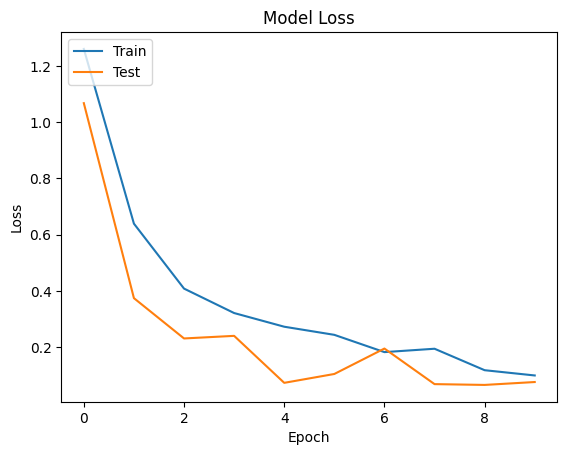

In [15]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [16]:
model.save_weights('./trained_model/weights.h5')
model.save('./trained_model/model.h5')

<h2>Load Model</h2>

In [17]:
reconstructed_model = tf.keras.models.load_model('./trained_model/model.h5')

<h2>Predicting an Image</h2>

In [18]:
from keras.utils import load_img, img_to_array

img = load_img('../dataset/test/inosuke/17.jpg', target_size=img_size)
img = img_to_array(img)
img = np.expand_dims(img, axis=0)

prediction = reconstructed_model.predict(img, verbose=0)

for j in range(5):
    if prediction[0][j] == 1. :
        print(class_list[j])
        break

inosuke


In [19]:
import requests
from io import BytesIO

link_path = "https://preview.redd.it/gm8surx0yop81.jpg?width=338&format=pjpg&auto=webp&s=ee0fdf6c3fbf3bdb7e08f58d7f2ccdd07291d58e"

response = requests.get(link_path)

img = tf.keras.utils.load_img(
    BytesIO(response.content), target_size=(img_height, img_width)
)

img = img_to_array(img)
img = np.expand_dims(img, axis=0)

prediction = reconstructed_model.predict(img, verbose=0)[0]

print(class_list[np.where(prediction==1)[0][0]])

tanjirou


## K-Fold Cross Validation

In [20]:
from sklearn.model_selection import KFold
import tensorflow_datasets as tfds

num_folds = 10

kfold = KFold(n_splits=num_folds, shuffle=True)
dataset_dir = '../dataset/processed/'

dataset = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  image_size=img_size
  )

# dataset = dataset.map(lambda x, y: (normalization_layer(x), y))
dataset = tfds.as_numpy(dataset)

inputs = next(iter(dataset))[0]
targets = next(iter(dataset))[1]

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

kfold_eval_model = reconstructed_model

fold_no = 1
for train, test in kfold.split(inputs, targets):
  history = kfold_eval_model.fit(
    inputs[train],
    targets[train],
    epochs=epochs,
    verbose=0
  )

  # Generate generalization metrics
  scores = kfold_eval_model.evaluate(inputs[test], targets[test], verbose=0)
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  print(f'Score for fold {fold_no}: {kfold_eval_model.metrics_names[0]} of {scores[0]:.2f}; {kfold_eval_model.metrics_names[1]} of {scores[1]*100}%')

  # Increase fold number
  fold_no = fold_no + 1

print(f'Accuracy: {np.mean(acc_per_fold)}')
print(f'Loss: {np.mean(loss_per_fold)}')

Found 498 files belonging to 5 classes.
Score for fold 1: loss of 76.84; accuracy of 0.0%
Score for fold 2: loss of 0.00; accuracy of 100.0%
Score for fold 3: loss of 4.18; accuracy of 66.66666865348816%
Score for fold 4: loss of 0.07; accuracy of 100.0%
Score for fold 5: loss of 0.00; accuracy of 100.0%
Score for fold 6: loss of 0.00; accuracy of 100.0%
Score for fold 7: loss of 0.00; accuracy of 100.0%
Score for fold 8: loss of 0.00; accuracy of 100.0%
Score for fold 9: loss of 0.00; accuracy of 100.0%
Score for fold 10: loss of 0.00; accuracy of 100.0%
Accuracy: 86.66666686534882
Loss: 8.109490556728087


In [21]:
test_ds_path = "../dataset/test/"

test_ds = tf.keras.utils.image_dataset_from_directory(test_ds_path, image_size=img_size, batch_size=batch_size, shuffle=False)

batch_ds = np.array(list(test_ds.as_numpy_iterator()), dtype=object)
batch_len =  batch_ds.shape[0]

y_pred = model.predict(test_ds, verbose=0, batch_size=batch_size)

y_true = np.array([])

for i in range(batch_len):
  y_true = np.concatenate((y_true, batch_ds[i][1]), axis=None)

y_pred = np.array([np.argmax(prediction) for prediction in y_pred])

print(y_pred)
tf.math.confusion_matrix(y_pred, y_true)

Found 50 files belonging to 5 classes.
[2 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 4 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4]


<tf.Tensor: shape=(5, 5), dtype=int32, numpy=
array([[ 9,  0,  0,  0,  0],
       [ 0,  9,  0,  0,  0],
       [ 1,  0, 10,  0,  0],
       [ 0,  0,  0, 10,  0],
       [ 0,  1,  0,  0, 10]])>

In [22]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=class_list))

                    precision    recall  f1-score   support

           inosuke       1.00      0.90      0.95        10
inosukewithoutmask       1.00      0.90      0.95        10
            nezuko       0.91      1.00      0.95        10
          tanjirou       1.00      1.00      1.00        10
           zenitsu       0.91      1.00      0.95        10

          accuracy                           0.96        50
         macro avg       0.96      0.96      0.96        50
      weighted avg       0.96      0.96      0.96        50

